**Happy Halloween 2019!**


Diving right in and import a few necessary libraries for this problem.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

Let's get the name of the folder that contains the train, test and the sample submission files

In [ ]:
import os
os.listdir("../input")


Import both the Train and Test 'csv' files as Pandas DataFrames 

In [ ]:
train=pd.read_csv("../input/ghouls-goblins-and-ghosts-boo/train.csv")
test=pd.read_csv("../input/ghouls-goblins-and-ghosts-boo/test.csv")

Let's check out the dimensions and also have a look at the first few rows of the Train dataset

In [ ]:
train.shape 
train.head()




So we have five weird features - **Bone_length, rotting_flesh, hair_length, has_soul and color** to find out the type of the creature.
Also, the 'id' column is just moot. Let's drop that

In [ ]:
train.drop('id',axis=1,inplace=True)
test1=test.drop('id',axis=1)


Let's get a few descriptive stats of our train dataset. 

In [ ]:
train.describe() 

Since we see that the values of all the features range just between 0 to 1 we don't need to implement any data scaling methods.

Do we have any missing values across all our featues?

In [ ]:
train.isnull().sum()


**ZERO!** There are no missing values.

What are the data types of the values these featues hold

In [ ]:
train.dtypes

The features **color** and **type** are of the 'object' type. We will have to convert them into numerical values before feeding them to the Machine Learning algorithms

How is the target variable distributed?

In [ ]:
train['type'].value_counts()

There are three classes in the target variable which are fairly evenly distributed.   

**Accuracy** as a scoring metric would be sufficient

Let's encode the two 'object' data type columns ('color' and 'type') in both Train and Test sets into numerical types 

In [ ]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
train['color']=label.fit_transform(train['color'])
train['type']=label.fit_transform(train['type'])

test1['color']=label.fit_transform(test1['color'])





pairplot by Seaborn shows that 'color' may not be of much help in seperation of the classes of target variable.

Also, notice that the features fairly follow Gaussian distributions (There are algorithms that assume that the data being fed has a Gaussian distribution and performs better when that's true)

In [ ]:
sns.pairplot(train,hue='type') 

Plotting a correlation matrix using heatmap by seaborn tells us the same thing about the 'color' feature. 



In [ ]:
sns.heatmap(train.corr(),annot=True,vmin=-1,vmax=1,cmap='RdYlGn')

Let's just drop 'color'

In [ ]:
train.drop('color',axis=1,inplace=True)
test1.drop('color',axis=1,inplace=True)

We now have to separate the features (independant variables) and the target feature (dependant variable) 

In [ ]:
X=train.drop('type',axis=1)
y=train['type']

Here's us importing quite a few popular Classification algorithms to try them all!

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

Classification_models=[('LogisticRegression',LogisticRegression()),('StochasticGDC',SGDClassifier()),('KNC',KNeighborsClassifier()),('SVC',SVC()),
                       ('LinearSVC',LinearSVC()),('GNaiveBayes',GaussianNB()),('MNaiveBayes',MultinomialNB()),('DTree',DecisionTreeClassifier()),
                       ('MLPerceptronC',MLPClassifier()),('RF',RandomForestClassifier()),('ET',ExtraTreesClassifier()),('AdaBoostC',AdaBoostClassifier()),
                       ('GBC',GradientBoostingClassifier()),('XGBC',XGBClassifier())]

Without getting into the details of hyperparameters of any of these classification algorithms lets see how they perform on our data. 

A simple train_test split may give you a very optimistic score compared to what you may get on new unseen data. Here we use cross validation to get more realistic estimates.

In [ ]:
result=[]
names=[]
for name,model in Classification_models:
    cvresult=cross_val_score(model,X,y,cv=5,n_jobs=-1,scoring = 'accuracy')
    result.append(cvresult.mean())
    names.append(name)
    print("%s gives %f " % (name, cvresult.mean()))

SVC and Gaussian Naive Bayes seem to be giving the best results (Remember that we had noticed in the pairplot that the features follow Gaussian distributions?)

Let's now try to tinker with the hyperparameters of SVC with the help of GridSearchCV (GaussianNB doesn't have any hyperparameters that you can further tune) to see if we can better our score.


In [ ]:
params={'C':[0.01,0.1,1],'gamma':[1,0.1,0.01],'kernel':['linear', 'poly', 'rbf'] }
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(SVC(),param_grid=params,n_jobs=-1,cv=5)
gridfit=grid.fit(X,y)

The best score and the SVC parameters that gave the best score are: 

In [ ]:
gridfit.best_score_
gridfit.best_params_


We'll make use of VotingClassifier on the predictions of SVC and GaussianNB to make our final predicitons on the test set 

In [ ]:

vc=VotingClassifier(estimators=[('Support Vector Classifier',SVC(C=1, gamma=1, kernel='linear')),
                                ('Gaussian Naive Bayes',GaussianNB())])

vc.fit(X,y)
predictions = vc.predict(test1)

The submission must be made in the form of a Pandas Dataframe with two columns - **id** and the predicted **type**

In [ ]:
submission = pd.DataFrame({'id':test['id'], 'type':predictions})

Here comes that step without which we get the coveted 'perfect score' of 0.0000 (Hence the title of this notebook)

This being my very first submission on Kaggle, I was ready to get a poor score but getting a 0.0000 stumped me. After about an hour of searching for mistakes I realised what the issue was.

The predictions we make for **type** is in the form of numericals (0,1 or 2) whereas Kaggle expects it to be 'Ghoul', 'Goblin' or 'Ghost'.
(This notebook gets a decent score of 0.733 now after setting that right)

**Moral of the story**- Always take a look at the 'sample_submission' file and don't miss the next step.


In [ ]:
submission['type']=label.inverse_transform(submission['type'])

Finally saving the submission dataframe as a 'csv' file.

In [ ]:
submission.to_csv('submission.csv', index=False)

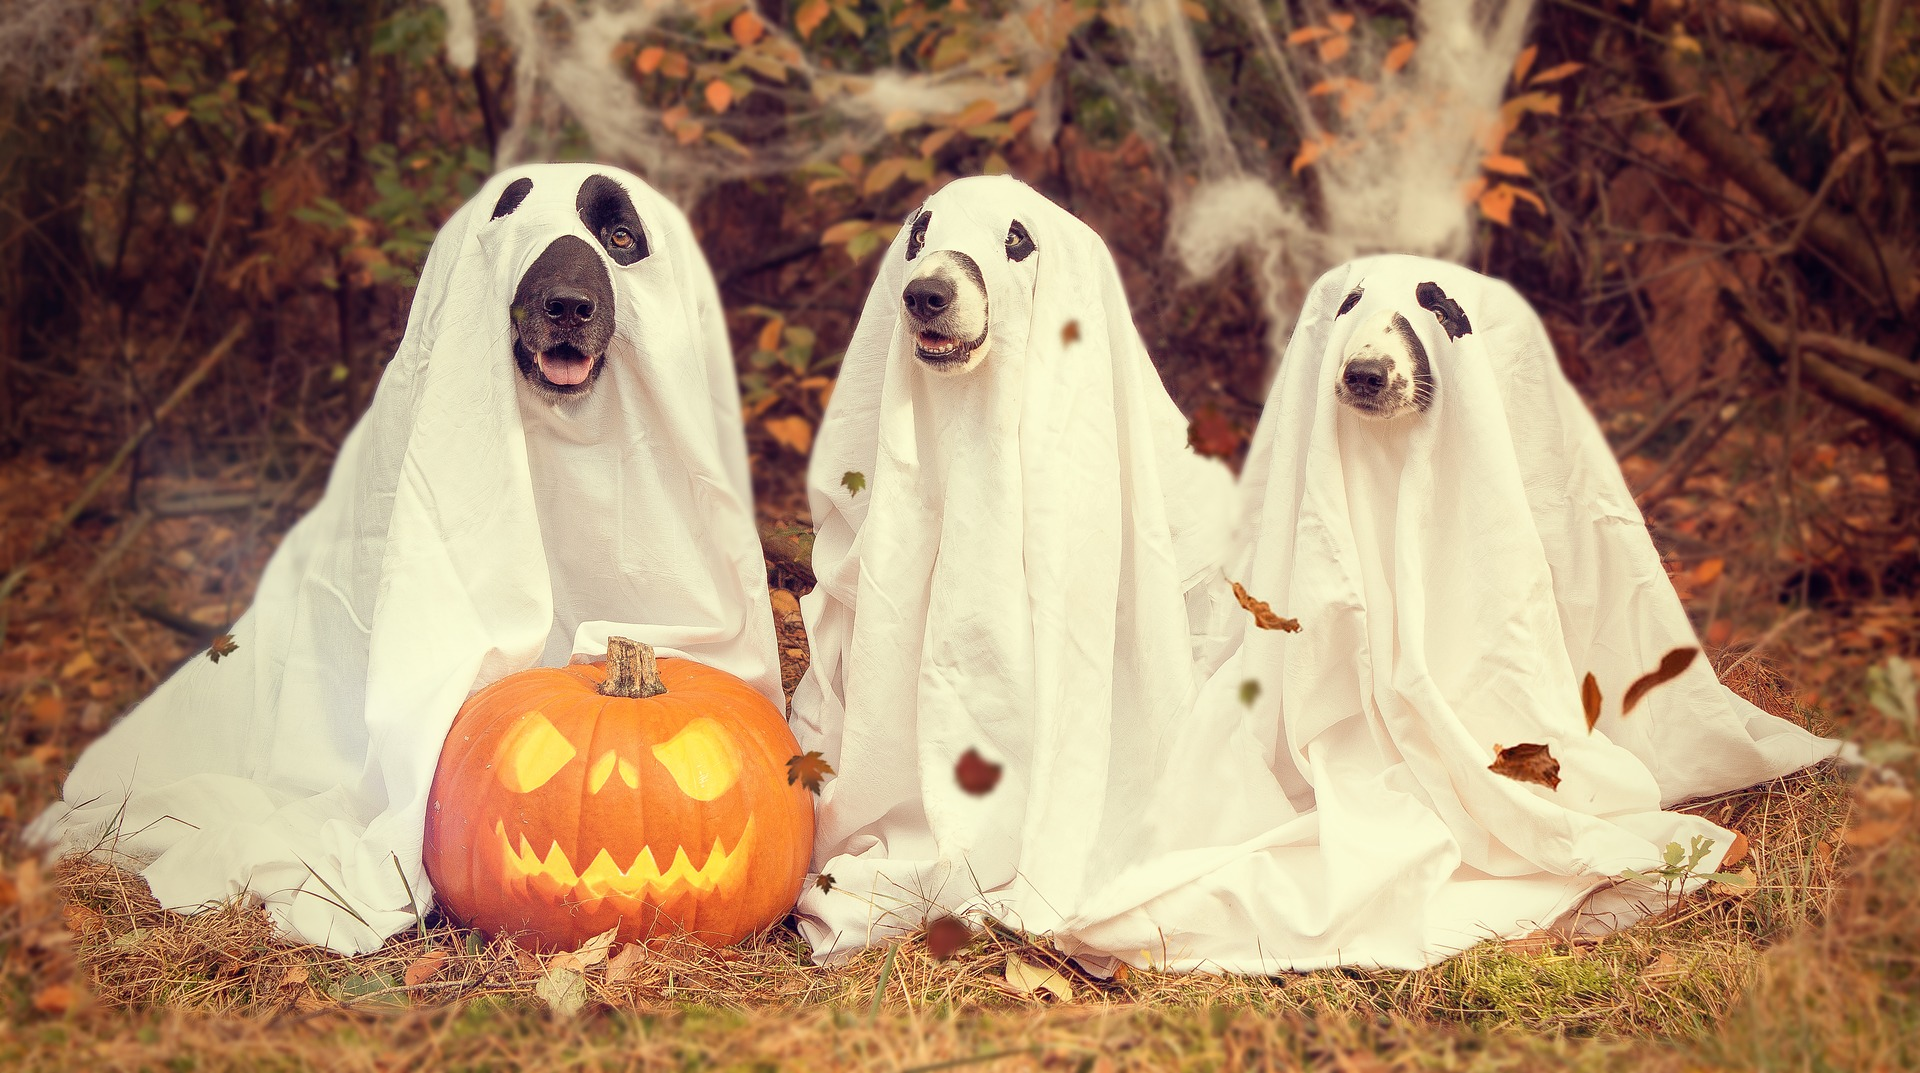

I wonder which Machine Learning model would classify these three guys correctly as ghosts though ;)

*Cheers!*